In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Task 2

## Data Information

In the provided file task2.csv, there was a dataset containing a set of static events captured during a season of professional football matches. The events were classified into three types:
* Pass: A pass performed between two players from a starting and ending position. Not all passes contain both starting and ending position
* Drive: Captures the spatial information during a ball drive. This is when the player chooses to keep the ball in that exact moment instead of performing any other action.
* Shot: Corresponds to shots. If the shot contains the destination location, it refers to the place where the shot was intercepted.

For each event, there was a series of additional statistics associated with that event, as well as additional metadata. It was noted that depending on the event, the question to be addressed, and the methodology, some of these stats might not have been necessary, or might even add noise to the model.

The additional statistics provided were detailed below:
* **match_id**: Unique id of the match where the event belongs to (string).
* **event_type**: The type name of the event (string).
* **team_name**: Name of the team executing the action (string).
* **start_frame**: Starting video frame of the event. All events are captured from a 25 frame per second video (int).
* **end_frame**: Ending video frame of the event (int).
* **success**: Whether is successful or not (string).
* **norm_origin_pos_x**: The x position of the event normalized from left to right (attacking direction) and in a [0,1] range (float).
* **norm_destination_pos_y**: The y position of the event normalized from left to right (attacking direction) and in a [0,1] range (float).
* **origin_player_name**: Name of the origin player (string).
* **destination_player_name**: Name of the destination player (string).
* **stat_relative_vertical_position_start**: According to the location of players we calculate three clusters for each team, the centroid line of those clusters represent the current formation lines. This stat, presented as numerical value in the [0,3] range represents the relative position of the player. 0 means the player is behind the first pressure line of the opponent (attackers). 1 means the player is between the attackers line and the midfield lines. 3 means the player is beyond the defenders line. (int)
* **stat_relative_horizontal_position_start**: With a similar approach than before lines are calculated horizontally. In this case these do not correspond to formation lines (vertical ones) but to relative width positioning. Values belong to a [0,3] range. [1,2] values mean the player is within the opponents formation box (horizontally) while [0,3] represent a position outside of the opponent box. This allows to differentiate playing by the inside or outside of the field. (int)
* **stat_relative_vertical_position_distance_start**: Distance in meters to the closest relative formation line (float)
* **stat_relative_horizontal_position_distance_start**: Distance in meters to the closest relative horizontal formation line (float)
* **stat_possession_team_vertical_centroids_start**: List of three values corresponding to the centroids of the vertical formation lines ([float])
* **stat_opponent_team_vertical_centroids_start**: List of three values corresponding to the centroids of the horizontal formation lines ([float])
* **stat_goal_distance**: Distance in meters to the opponent goal (float)
* **stat_closest_defender_distance**: Distance in meters to closest defender (float)
* **shot_angle**: Angle from the location vector to an horizontal vector departing from the mid goal position [1,0.5] (float)
* **stat_opponents_blockage_count**: Number of opponents blocking the ball at a 30 degrees angle to the goal.
* **stat_attack_result**: Information about how the attack to which the event belongs to ends. Goal, Shot or No Shot (string)
* **stat_xg**: Expected goals value given the player takes a shot from the current location [0,1] range (float)
* **pos_players_tracking**: Spatio-temporal information of all the players of the team in possession of the ball at the time of the event. It contains X and Y coordinates, speed and player name (list).
* **opp_players_tracking**: Spatio-temporal information of all the players of the team out of possession at the time of the event. It contains X and Y coordinates, speed and player name (list).

## Task Information

Based on this data, I was tasked with developing a pass probability model. An accurate pass probability model would provide a [0,1] outcome of a successful pass given a set of covariates or features of the current state of the game. I considered the following during the development process:

* Some features might not be needed or accurate for this problem
* Some features might provide better information for this problem if they were transformed
* There are missing values for some features
* The objective is to have an accurate probability of a pass. I wanted to provide explanations of why my model was a good probability estimator.
* Sports analytics urges for a balance between precision and explanaibility. Therefore, I provided information about the most relevant variables of my model.

I found interesting code snippets and algorithms for tracking data in the [Friends of Tracking Repository](https://github.com/Friends-of-Tracking-Data-FoTD/) and [their YouTube channel](https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w).

## Solution

In [32]:
df_events = pd.read_csv("task2.csv")

### Data cleaning and preparation

Before creating the model, it was important to examine the properties of the dataset, address any issues identified, convert or transform existing variables, and even create new ones derived from the already available ones. It was also crucial to determine if any feature engineering was necessary to enhance the dataset's usefulness and to remove unimportant columns.

In [279]:
# Drop columns and rows that do not have importance for pass events
df_passes = df_events.loc[df_events['event_type'] == 'Pass'].drop(['shot_angle','stat_opponents_blockage_count',
                                                                   'stat_attack_result','stat_xg'], axis=1)

# I drop these columns that could be useful in a more advanced model that detects how many lines are being passed through or the
# distance between opposing lines where the destination player is between, speed of opposing players or destination player, ...
df_passes = df_passes.drop(['opp_players_tracking','pos_players_tracking', 'stat_opponent_team_vertical_centroids_start',
                            'stat_possession_team_vertical_centroids_start'], axis=1)

# Since we have a lot of null values in the destination player, and I prefer not to drop that many rows and it is not easy
# to impute it from the data, I will not use it nor consider who is receiving the pass to determine its successfullness
df_passes = df_passes.drop(['origin_player_name','destination_player_name'], axis=1)

# We drop columns with empty values in some column
df_passes.dropna(inplace=True)

# Convert successful column into binary
df_passes['success'] = np.where(df_passes['success']=='Successful',1,0)

# I transform the 'stat_relative_horizontal_position_start' into a binary column, 0,3 -> 0 = outside & 1,2 -> 1 = inside
df_passes['stat_relative_horizontal_position_start'] = np.where((df_passes['stat_relative_horizontal_position_start'] == 0.0) 
                                                                | (df_passes['stat_relative_horizontal_position_start'] == 3.0), 0, 1)

# Convert column to integer
df_passes['stat_relative_vertical_position_start'] = df_passes['stat_relative_vertical_position_start'].astype(int)

# Drop irrelevant columns
df_passes = df_passes.drop(['match_id','event_type','start_frame','end_frame','team_name'],axis=1)

# We create a column to determine distance of the pass
w = 105
h = 68

df_passes['pass_distance'] = np.sqrt((w*df_passes['norm_destination_pos_x'] - w*df_passes['norm_origin_pos_x']) ** 2 +\
                                (h*df_passes['norm_destination_pos_y'] - h*df_passes['norm_origin_pos_y']) ** 2)

With the data that we have, we do not have a very broad number of features, or any spectacular variable that can really determine what is the probability of that pass being successful. I believe with more time, and with some of the variables I did not use and some feature engineering we could create even more useful columns that could improve the models we will create.

### Sampling

Since we have a very unbalanced dataset and I don't want to delete so many events, I decided to apply a bit of sampling. In this case, I decided to do a bit of undersampling of the most common class and oversampling of the least common to make it more balanced. If we do not do this, then the models that we generate will only predict the majority as 'Successful' which is the most common one, and get a high accuracy, but this is not the objective of the model.

In [35]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

# Here we are using the imbalanced dataset 
df_passes_linreg = df_passes.copy()
X = df_passes_linreg.drop('success', axis=1)
y = df_passes_linreg['success']

# Define the pipeline process
oversampling = SMOTE(sampling_strategy=0.7)
undersampling = RandomUnderSampler(sampling_strategy=0.9)
steps = [('o', oversampling), ('u', undersampling)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
X_transform, y_transform = pipeline.fit_resample(X, y)

# Original class distribution
counter_original = Counter(y)
print("Original class distribution:", counter_original)

# New class distribution
counter_transform = Counter(y_transform)
print("New class distribution:", counter_transform)

# New df
columns_names = df_passes_linreg.columns
balanced_df = pd.DataFrame(data = X_transform)
balanced_df['success'] = y_transform

Original class distribution: Counter({1: 105270, 0: 28687})
New class distribution: Counter({1: 81876, 0: 73689})


### Modelling

The functions below will help to train all models and display their performance in a standarized way.

In [243]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve

# We create a function to plot distributions
def plot_dist(bad, good, attr, title):

    f,axes = plt.subplots(1,3,figsize=(20,5), sharex=True)

    ax1 = sns.distplot(bad[attr], color="crimson",ax=axes[0], bins=30, 
                     hist_kws=dict(edgecolor="crimson",linewidth=2))

    ax2 = sns.distplot(good[attr], color="blueviolet",ax=axes[1], bins=30, 
                     hist_kws=dict(edgecolor="blueviolet",linewidth=2))

    ax3 = sns.kdeplot(bad[attr], color="crimson",ax=axes[2], legend=False)
    ax3 = sns.kdeplot(good[attr], color="blueviolet",ax=axes[2], legend=False)
    ax3.set_xlabel(attr)
    
    sns.despine(top=True, right=True)

    f.text(0.07,0.5,'Frequency',va='center',rotation='vertical')
    f.suptitle(f'{attr} Histogram', fontsize=14)
    f.legend(labels=['Failed Pass','Successful Pass'], loc=1,borderaxespad=7)

def train_model_and_performance_eval(model,train_x,test_x,train_y,test_y, cols, title, cf, cutoff):

    # Fit the model (train)
    model.fit(train_x,train_y)
    
    # Calculate its predictions (0, 1) and their probability 
    predictions = model.predict(test_x)
    probabilities = model.predict_proba(test_x)
    
    # Modify the prediction value according to the cutoff value
    predictions = np.where(probabilities[:,1]>= cutoff,1,0)
    
    # Calculate the coefficients dataframe depending on if they are real coefficients or features
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(model.coef_.ravel())
        
    elif cf == "features" :
        coefficients  = pd.DataFrame(model.feature_importances_)
    
    # Set the coefficients to be shown
    if cf != 'coefs':
        column_df     = pd.DataFrame(cols)
        coef_sumry    = (pd.merge(coefficients,column_df,left_index= True, right_index= True, how = "left"))
        coef_sumry.columns = ["coefficients","features"]
        coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    # Print the accuracy and classification reports (see accuracy_score and classification_report functions)
    print(f'{logit}\n\nClassification report:\n{classification_report(test_y,predictions)}')
    print(f'\nAccuracy Score: {accuracy_score(test_y,predictions)}')
    
    # Plot confusion matrix (see plot_confusion_matrix function)
    plot_confusion_matrix(model, test_x, test_y, cmap=plt.cm.Reds)
    plt.grid(False)

    # Plot the probability density chart 
    model_and_real_values=pd.DataFrame({"real_value":predictions, "predicted_value":probabilities[:,1]})
    plot_dist(bad=model_and_real_values[model_and_real_values.real_value==0], 
              good=model_and_real_values[model_and_real_values.real_value==1],
              attr="predicted_value", title=title)
    
    if cf != 'coefs':
        # Plot feature importance bar
        # Prepare Data
        coef_sumry.reset_index(inplace=True)
        coef_sumry['colors'] = ['red' if x < 0 else 'green' for x in coef_sumry['coefficients']]
        coef_sumry

        # Draw plot
        plt.figure(figsize=(14,10), dpi= 80)
        plt.hlines(y=coef_sumry.index, xmin=0, xmax=coef_sumry.coefficients, color=coef_sumry.colors, alpha=0.4, linewidth=5)

        # Decorations
        plt.gca().set(ylabel='$Features$', xlabel='$Coefficients$')
        plt.yticks(coef_sumry.index, coef_sumry.features, fontsize=12)
        plt.title('Feature Importance', fontdict={'size':20})
        plt.grid(linestyle='--', alpha=0.5)


Now, we separate our model into train, validation and testing datasets.

In [287]:
# Define model df
model_df = balanced_df.copy()

# Getting columns to be used when training
cols = [i for i in model_df.columns if i not in ("success")]

# Split train, validation and test data
train_val, test = train_test_split(model_df, test_size = .1 ,random_state = 1)
train, val = train_test_split(train_val, test_size = .3 ,random_state = 1)

train_x = train[cols]
train_y = train["success"]
val_x = val[cols]
val_y = val["success"].values.ravel()

#### Logistic regression

The first model is going to be a very simple one, to start things of. As seen below, it has an naccuracy of around 70% and we can see the features that we have are not greatly rated by this model. I believe it is not a good approach for our purpose, but I think it is always a good start to try a simple model.

LogisticRegression(solver='liblinear')

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68     19929
           1       0.71      0.73      0.72     22074

    accuracy                           0.70     42003
   macro avg       0.70      0.70      0.70     42003
weighted avg       0.70      0.70      0.70     42003


Accuracy Score: 0.6989976906411447


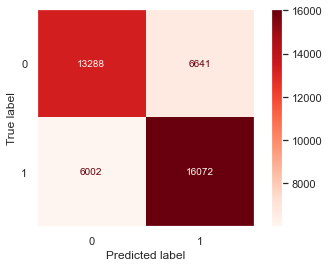

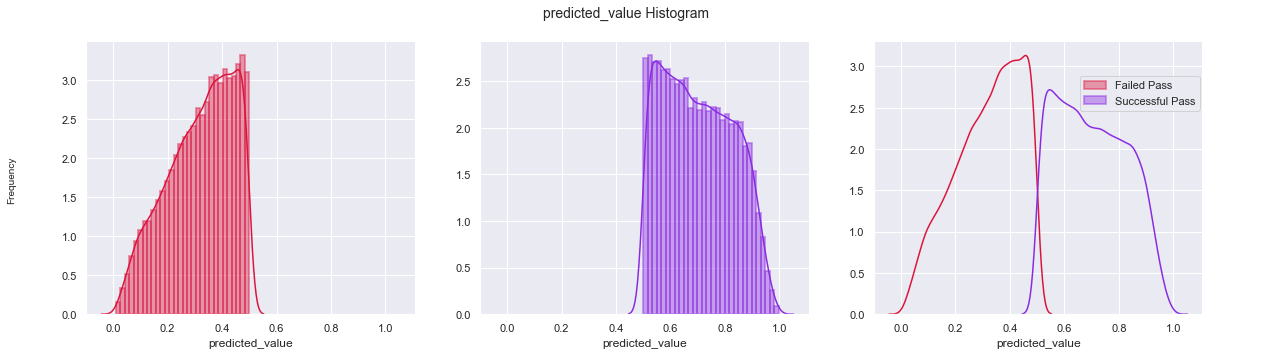

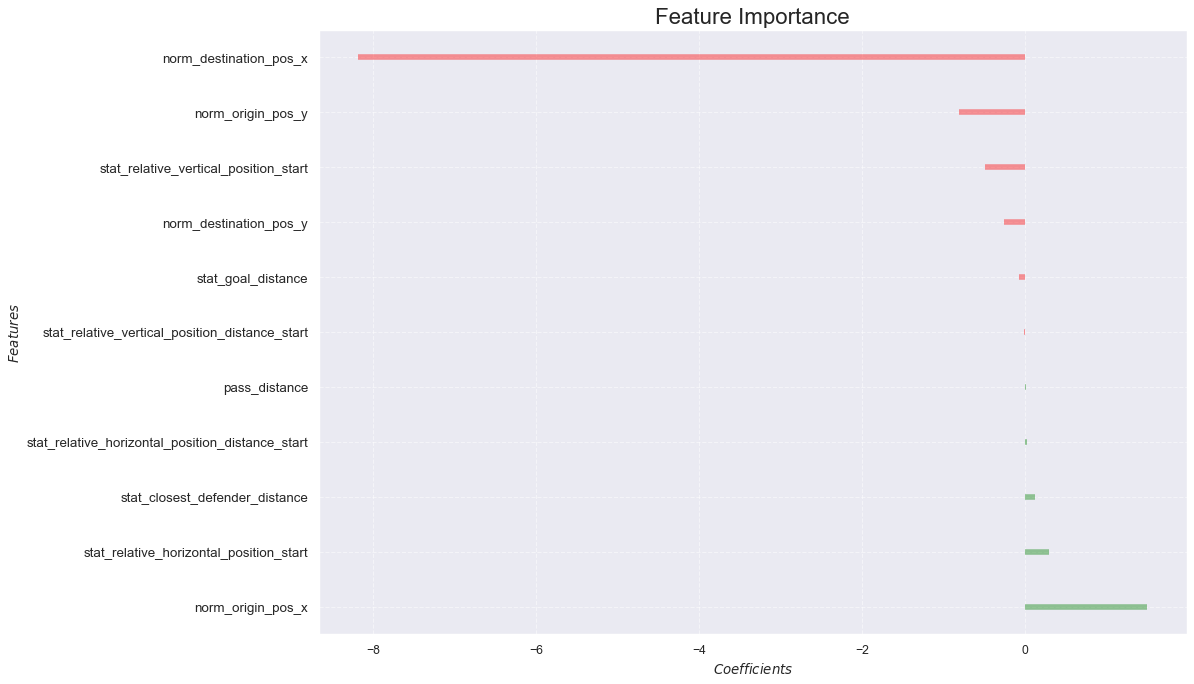

In [288]:
# Change the hyperparameters in order and try to get the best model 
logit  = LogisticRegression(C=1.0, max_iter=100, solver='liblinear')

# Train the model
predictions = train_model_and_performance_eval(logit, train_x, val_x, train_y, val_y, cols, 
                                               cutoff = 0.5, title='logitmodel1', cf = 'coefficients') 

#### Ada Boost

I believe Ensamble mthods are quite good models, and could have good results for our use case. As seen we have signifficantly improved the quality of the results, with a model that has an accuracy of around 78-79%. It is quite better, but still it is not a great model. As seen in the last graph the features are working quite better too.

LogisticRegression(solver='liblinear')

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77     19929
           1       0.78      0.84      0.81     22074

    accuracy                           0.79     42003
   macro avg       0.79      0.79      0.79     42003
weighted avg       0.79      0.79      0.79     42003


Accuracy Score: 0.7898007285193914


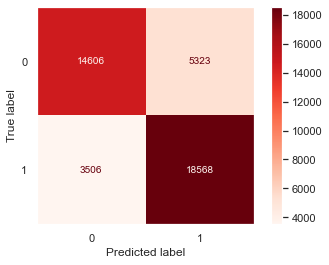

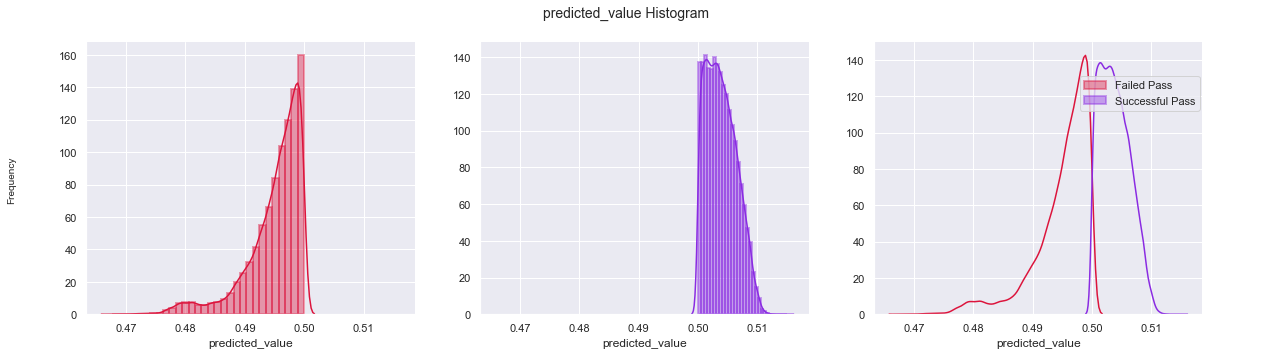

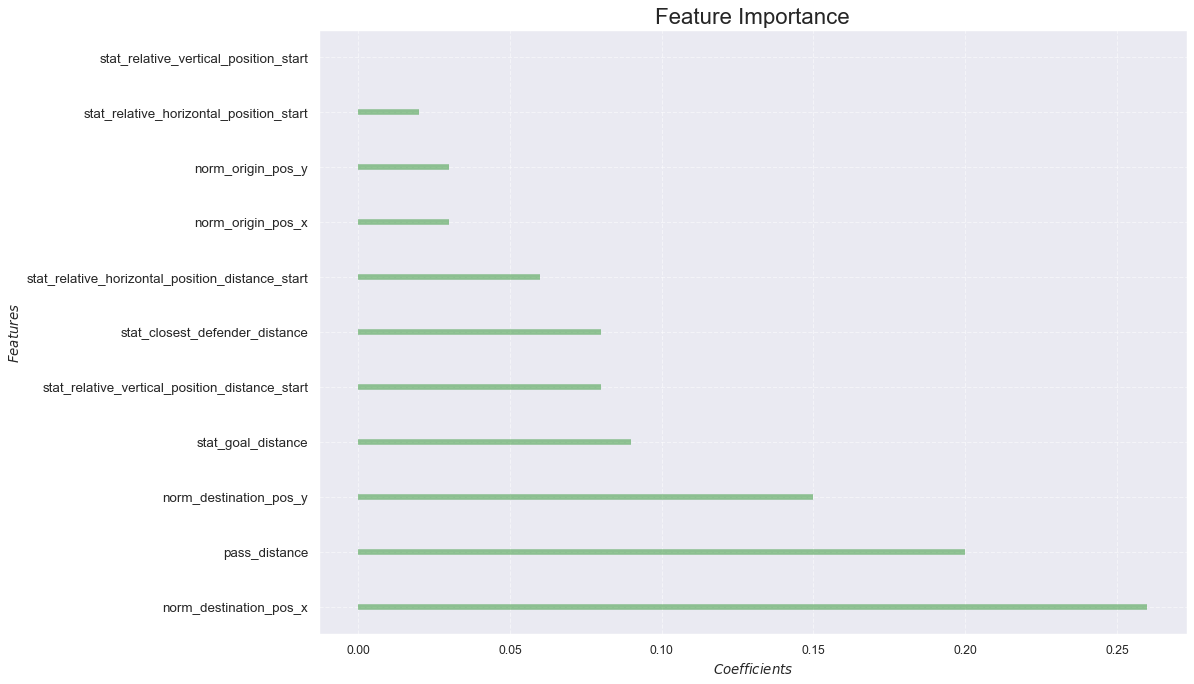

In [293]:
# Change the hyperparameters in order and try to get the best model 
ada_class = AdaBoostClassifier(random_state=0, n_estimators=100)

# Train the model
predictions = train_model_and_performance_eval(ada_class, train_x, val_x, train_y, val_y, cols, 
                                               cutoff = 0.5, title='ada_classmodel', cf='features') 

#### Multi-layer Perceptron

For the next model, I wanted to try a simple neural network model. As seen below, it has a similar performance to the previous model, thus making it not very good since it takes a reasonably bigger amount of time to train.

LogisticRegression(solver='liblinear')

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.75     19929
           1       0.76      0.84      0.80     22074

    accuracy                           0.78     42003
   macro avg       0.78      0.77      0.77     42003
weighted avg       0.78      0.78      0.78     42003


Accuracy Score: 0.7769445039640026


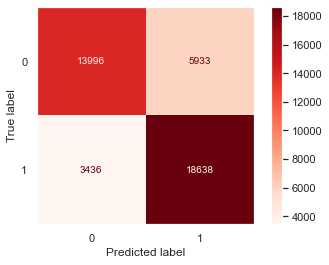

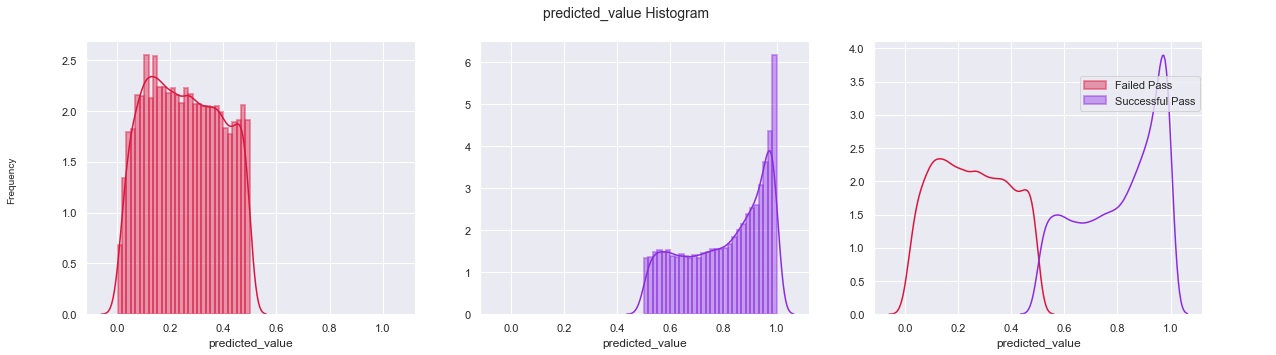

In [290]:
# Change the hyperparameters in order and try to get the best model 
mlp = MLPClassifier(random_state=1, max_iter=500)

# Train the model
predictions = train_model_and_performance_eval(mlp, train_x, val_x, train_y, val_y, cols, 
                                               cutoff = 0.5, title='mlp_model', cf='coefs')

#### GradientBoosting

Back t oensambling models, I decided to use this boosting classifier. We got an increase of performance of around 2% with respect to the last two models, so this really shows ensamble models are qorking quite well for our use-case. In this model we can see that the pass distance is what really has the most importance when presicting the outcome of the pass. Still I don't believe this is a super great model and it can be better.

LogisticRegression(solver='liblinear')

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78     19929
           1       0.80      0.83      0.81     22074

    accuracy                           0.80     42003
   macro avg       0.80      0.80      0.80     42003
weighted avg       0.80      0.80      0.80     42003


Accuracy Score: 0.8005856724519678


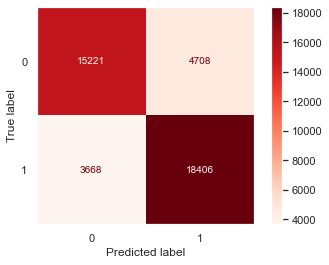

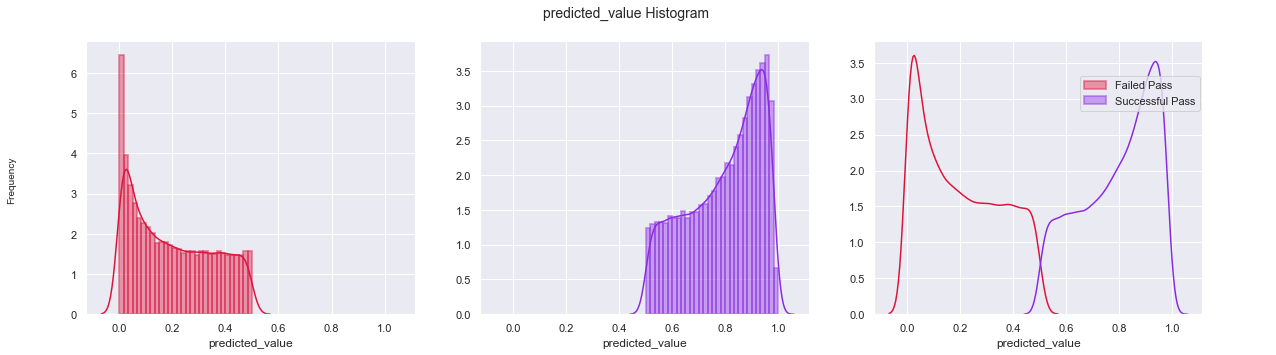

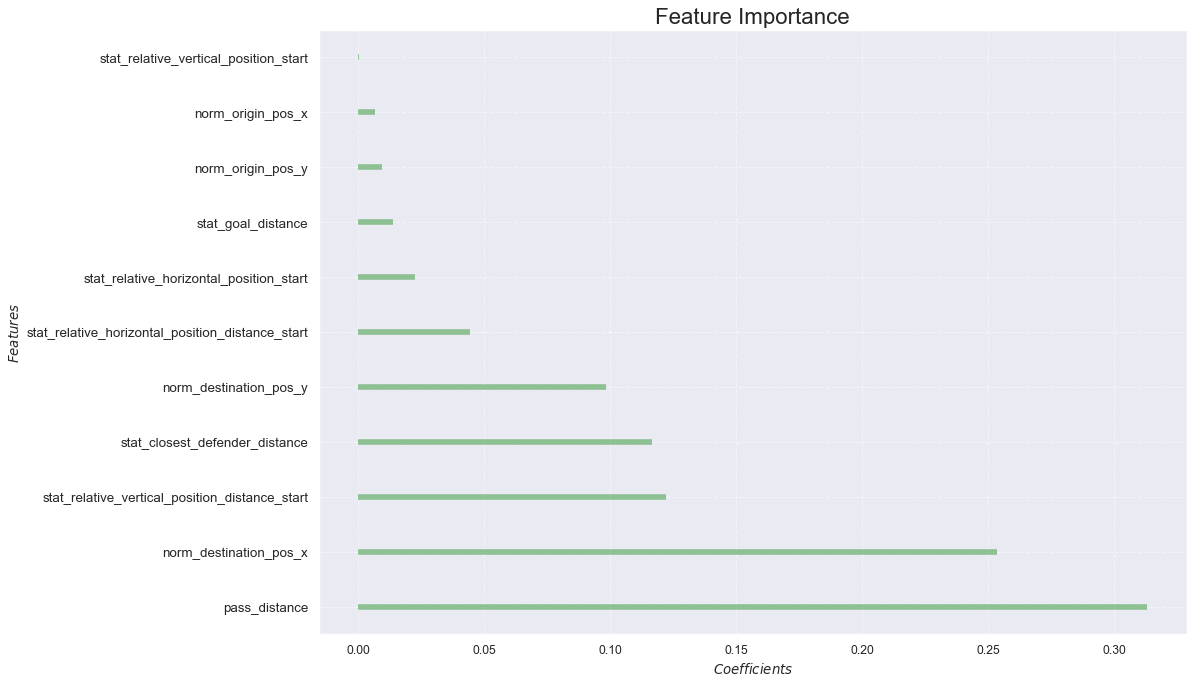

In [291]:
# Change the hyperparameters in order and try to get the best model 
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0,max_depth=1, random_state=0)

# Train the model
predictions = train_model_and_performance_eval(gbc, train_x, val_x, train_y, val_y, cols, 
                                               cutoff = 0.5, title='forestmodel', cf='features') 

#### Random Forest

Finally, the last ansd best model is a Random Forest classifier, which I have to do some basic fine-tuning to extract the best performance possible. The model is really fast to train and gets quite good results. It has a prediction accuracy of more than 85%. The most important features make a lot of sense. Firstly, the distance of the passis crucial since longer passes are always going to be harder to make. Secondly and quite closely, the location of the destination player has a lot of influence. The same type of pass in the middle of the pitch is never going to be defended as hard as an equal pass in front of the rivals box. On the third place, we see that the distance to the closest defender is also highly influential in the prediction outcome, which makes also a lot of sense. I will choose this model to continue with the project.

LogisticRegression(solver='liblinear')

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     19929
           1       0.87      0.85      0.86     22074

    accuracy                           0.86     42003
   macro avg       0.86      0.86      0.86     42003
weighted avg       0.86      0.86      0.86     42003


Accuracy Score: 0.8564388257981572


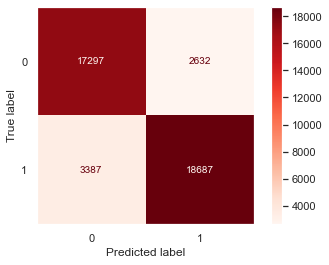

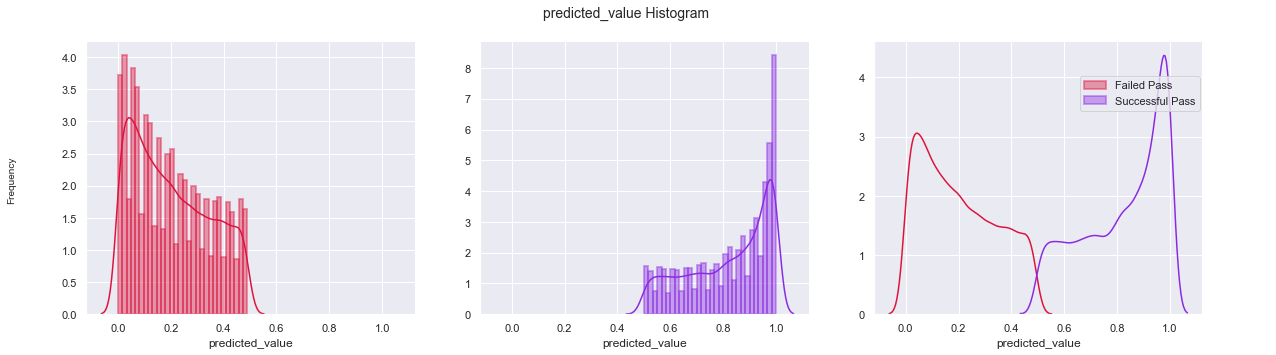

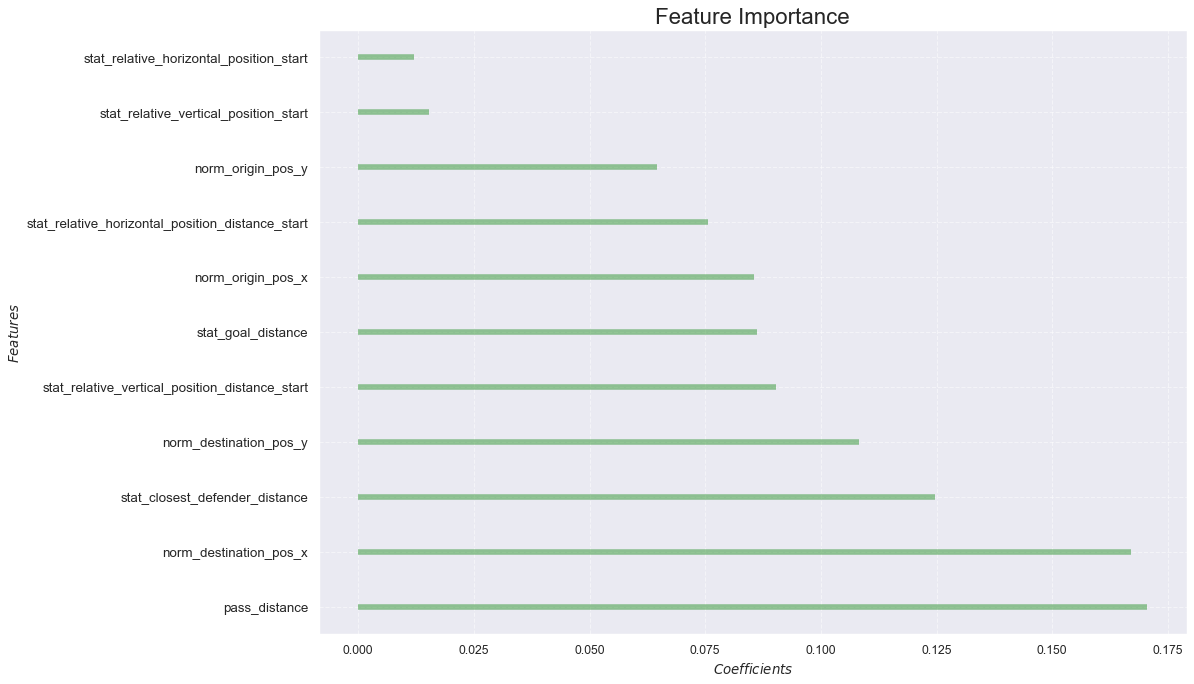

In [296]:
# Change the hyperparameters in order and try to get the best model 
rfc = RandomForestClassifier(max_depth=50)

# Train the model
predictions = train_model_and_performance_eval(rfc, train_x, val_x, train_y, val_y, cols, 
                                               cutoff = 0.5, title='forestmodel', cf='features')  

## Visualization task

The code below provides a shortcut for drawing a 2D football field. I tried using this code to showcase some characteristics of my passing model, the passing characteristics of teams and players, and any useful visual evaluations that could be obtained from the model.

In [129]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np


ww = 105
hh = 68

# transform [0,1] range points to meters
def point_to_meters(p, width=ww, height=hh):
    return np.array([p[0] * width, p[1] * height])


# transform meters range points to [0,1] range points
def meters_to_points(p,  width=ww, height=hh):
    return np.array([p[0] / float(width), p[1] / float(height)])
 
    
def draw_field(fig_size=8, lines_color="#bcbcbc", background_color="white"):
    """
    Draw a 2D football field
    """
    ratio = ww / float(hh)
    f, ax = plt.subplots(1, 1, figsize=(fig_size * ratio, fig_size), dpi=100)

    ax.add_patch(patches.Rectangle((0, 0), ww, hh, color=background_color, alpha=0))

    line_pts = [
        [point_to_meters([0, 0]), point_to_meters([0, 1])],
        [point_to_meters([1, 0]), point_to_meters([1, 1])],
        [point_to_meters([0, 1]), point_to_meters([1, 1])],  
        [point_to_meters([0, 0]), point_to_meters([1, 0])],
    ]

    for line_pt in line_pts:
        ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-', alpha=0.8,
                lw=1.5, zorder=2, color=lines_color)

    line_pts = [
        [point_to_meters([0.5, 0]), point_to_meters([0.5, 1])],

        [[0, 24.85], [0, 2.85]],
        [[0, 13.85], [16.5, 13.85]],
        [[0, 54.15], [16.5, 54.15]],
        [[16.5, 13.85], [16.5, 54.15]],

        [[0, 24.85], [5.5, 24.85]],
        [[0, 43.15], [5.5, 43.15]],
        [[5.5, 24.85], [5.5, 43.15]],

        [[105, 24.85], [105, 2.85]],
        [[105, 13.85], [88.5, 13.85]],
        [[105, 54.15], [88.5, 54.15]],
        [[88.5, 13.85], [88.5, 54.15]],

        [[105, 24.85], [99.5, 24.85]],
        [[105, 43.15], [99.5, 43.15]],
        [[99.5, 24.85], [99.5, 43.14]]
    ]

    for line_pt in line_pts:
        ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
                alpha=0.8, lw=1.5, zorder=2, color=lines_color)
    
    # Circles
    ax.add_patch(patches.Wedge((94.0, 34.0), 9, 128, 232, fill=True, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02))

    ax.add_patch(patches.Wedge((11.0, 34.0), 9, 308, 52, fill=True, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02))

    ax.add_patch(patches.Wedge((52.5, 34), 9.5, 0, 360, fill=True, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02))

    plt.axis('off')
    
    return ax

#### Analysis 1
Firstly, I will show for 10 random passes and show the predicted success value. As seen below, the model predicts that very long passes that have a destination x very close to the rival box will not succeed. This is in line with the explainability of the model we selected.

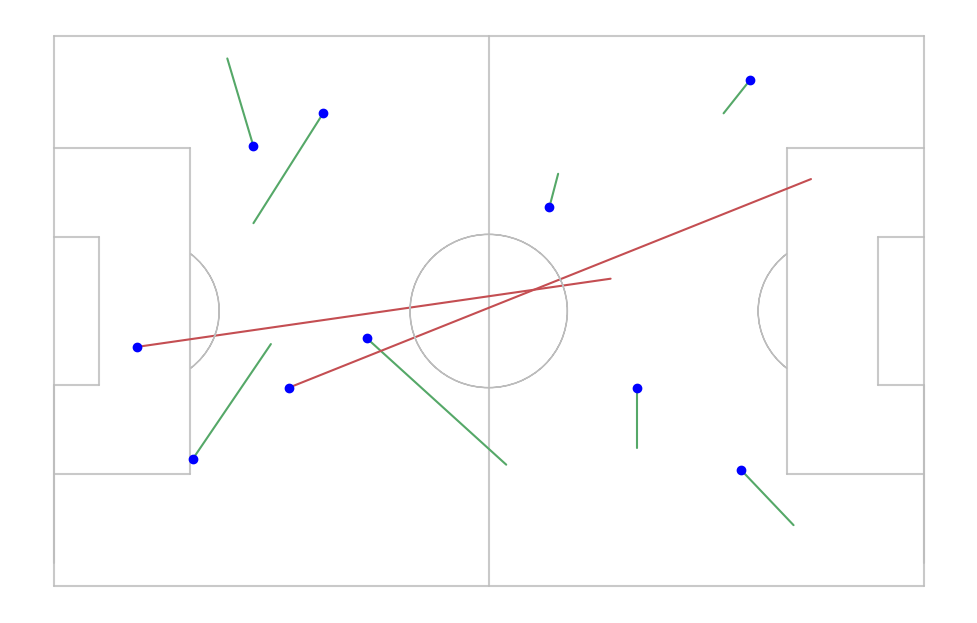

In [297]:
ax = draw_field()

# add your code here
df_draw = test.sample(n=10).copy()

ax.scatter(df_draw["norm_origin_pos_x"]*ww,df_draw["norm_origin_pos_y"]*hh, color='blue', zorder=10)

df_draw_success = df_draw[df_draw['success'] == 1]
df_draw_failed  = df_draw[df_draw['success'] == 0]

x_values_success = [df_draw_success["norm_origin_pos_x"]*ww,df_draw_success["norm_destination_pos_x"]*ww]
y_values_success = [df_draw_success["norm_origin_pos_y"]*hh,df_draw_success["norm_destination_pos_y"]*hh]

x_values_failed = [df_draw_failed["norm_origin_pos_x"]*ww,df_draw_failed["norm_destination_pos_x"]*ww]
y_values_failed = [df_draw_failed["norm_origin_pos_y"]*hh,df_draw_failed["norm_destination_pos_y"]*hh]

ax.plot(x_values_success, y_values_success, color='g', linestyle="-")
ax.plot(x_values_failed,  y_values_failed,  color='r', linestyle="-")

plt.show()

#### Analysis 2

Now, I will also select 10 random passes and do a comparison of how our model performs and compare the predicted and real success values. As seen in the plots and arrays below, the model predicts correcly 9/10 passes and all of them are clearly classified without any problem. The one wrongly classified was quite close to the cutoff so I believe this also indicated the a good performance of our model.

In [232]:
true_labels = test.sample(n=10).copy()
df_draw_model = true_labels.drop('success',axis=1)

# Calculate its predictions (0, 1) and their probability
predictions = rfc.predict(df_draw_model)
probabilities = rfc.predict_proba(df_draw_model)

# Modify the prediction value according to the cutoff value
predictions = np.where(probabilities[:,1]>= 0.5,1,0)

# Calculate the coefficients dataframe depending on if they are real coefficients or features
coefficients  = pd.DataFrame(rfc.feature_importances_)
predictions, probabilities[:,1]

(array([0, 0, 1, 1, 0, 1, 1, 1, 0, 1]),
 array([0.27, 0.47, 0.52, 0.75, 0.12, 0.97, 0.91, 0.68, 0.08, 0.99]))

In [ ]:
df_draw_model['success'] = true_labels['success']
df_draw_model['predict_success'] = pd.DataFrame(predictions, index=df_draw_model.index, columns={'predict_success':0})

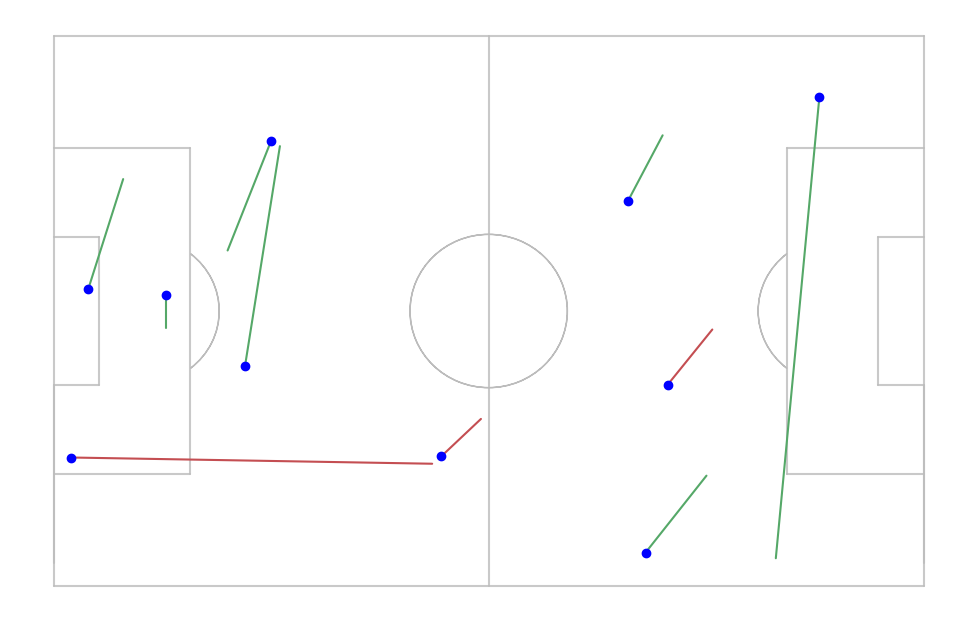

In [240]:
# Original succes results
ax = draw_field()

ax.scatter(df_draw_model["norm_origin_pos_x"]*ww,df_draw_model["norm_origin_pos_y"]*hh, color='blue', zorder=10)

df_draw_success = df_draw_model[df_draw_model['success'] == 1]
df_draw_failed  = df_draw_model[df_draw_model['success'] == 0]

x_values_success = [df_draw_success["norm_origin_pos_x"]*ww,df_draw_success["norm_destination_pos_x"]*ww]
y_values_success = [df_draw_success["norm_origin_pos_y"]*hh,df_draw_success["norm_destination_pos_y"]*hh]

x_values_failed = [df_draw_failed["norm_origin_pos_x"]*ww,df_draw_failed["norm_destination_pos_x"]*ww]
y_values_failed = [df_draw_failed["norm_origin_pos_y"]*hh,df_draw_failed["norm_destination_pos_y"]*hh]

ax.plot(x_values_success, y_values_success, color='g', linestyle="-")
ax.plot(x_values_failed,  y_values_failed,  color='r', linestyle="-")

plt.show()

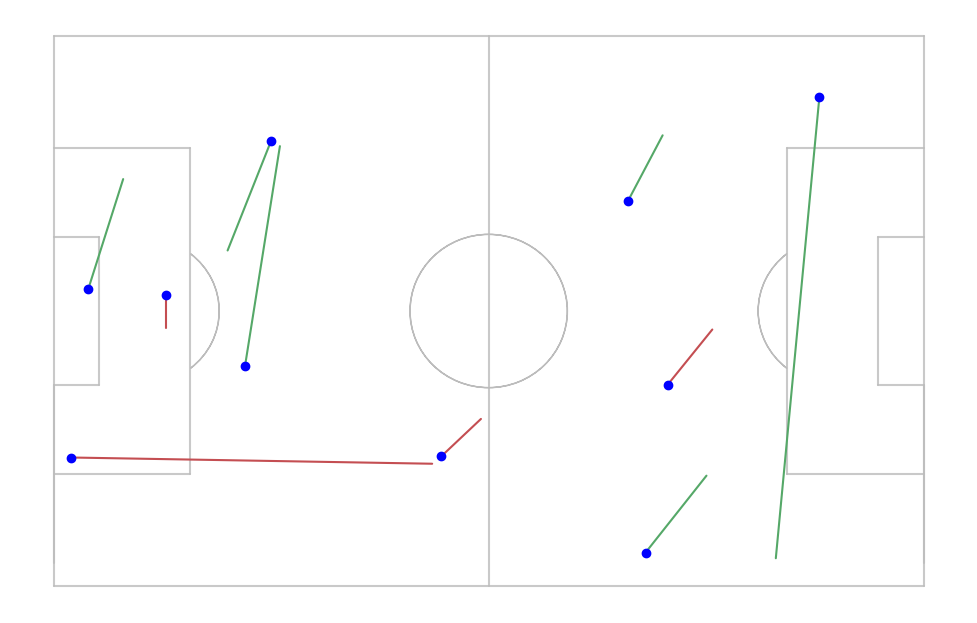

In [241]:
# Predicted success results
ax = draw_field()

ax.scatter(df_draw_model["norm_origin_pos_x"]*ww,df_draw_model["norm_origin_pos_y"]*hh, color='blue', zorder=10)

df_draw_success = df_draw_model[df_draw_model['predict_success'] == 1]
df_draw_failed  = df_draw_model[df_draw_model['predict_success'] == 0]

x_values_success = [df_draw_success["norm_origin_pos_x"]*ww,df_draw_success["norm_destination_pos_x"]*ww]
y_values_success = [df_draw_success["norm_origin_pos_y"]*hh,df_draw_success["norm_destination_pos_y"]*hh]

x_values_failed = [df_draw_failed["norm_origin_pos_x"]*ww,df_draw_failed["norm_destination_pos_x"]*ww]
y_values_failed = [df_draw_failed["norm_origin_pos_y"]*hh,df_draw_failed["norm_destination_pos_y"]*hh]

ax.plot(x_values_success, y_values_success, color='g', linestyle="-")
ax.plot(x_values_failed,  y_values_failed,  color='r', linestyle="-")

plt.show()

#### Analysis 3

Now I will select 50 random passes and see how good the model is working, and we can also see if the results are in line with the characteristics of the model and the feature importance. As seen in the plot, the typical passes being predicted as failed are long passes closer to the opponent goal.

Depending on the execution, we normally get results between 42-48 of the 50 passes being corrreclty predicted. For hthis simple model, I believe it is quite good performance. 

In [333]:
true_labels = test.sample(n=50).copy()
df_draw_model = true_labels.drop('success',axis=1)

# Calculate its predictions (0, 1) and their probability
predictions = rfc.predict(df_draw_model)
probabilities = rfc.predict_proba(df_draw_model)

# Modify the prediction value according to the cutoff value
predictions = np.where(probabilities[:,1]>= 0.5,1,0)

# Calculate the coefficients dataframe depending on if they are real coefficients or features
coefficients  = pd.DataFrame(rfc.feature_importances_)

# Insert true and predicted values
df_draw_model['success'] = true_labels['success']
df_draw_model['predict_success'] = pd.DataFrame(predictions, index=df_draw_model.index, columns={'predict_success':0})

# Now we show rows which were predicted incorrectly
df_draw_model.loc[df_draw_model['success'] != df_draw_model['predict_success']]

,norm_origin_pos_x,norm_origin_pos_y,norm_destination_pos_x,norm_destination_pos_y,stat_relative_vertical_position_start,stat_relative_horizontal_position_start,stat_relative_vertical_position_distance_start,stat_relative_horizontal_position_distance_start,stat_goal_distance,stat_closest_defender_distance,pass_distance,success,predict_success
38105,0.407540,0.284990,0.527592,0.304991,0,0,44.515395,49.118134,65.495213,2.620876,13.161259,0,1
130639,0.289729,0.879969,0.439778,0.829999,0,0,29.322546,70.422550,79.307935,1.895479,16.117373,1,0
93225,0.630239,0.340076,0.690241,0.340076,2,1,65.408067,60.394953,40.319133,1.630942,6.300216,1,0
11004,0.520163,0.930268,0.470176,0.840307,2,0,53.570634,67.387077,58.262142,0.479428,8.060409,0,1
23028,0.689888,0.890011,0.729947,0.929983,1,0,70.887743,91.925010,42.492362,3.811480,5.008056,0,1
105048,0.269699,0.169644,0.439778,0.129706,1,0,23.995354,28.597784,79.904353,2.320721,18.063550,1,0


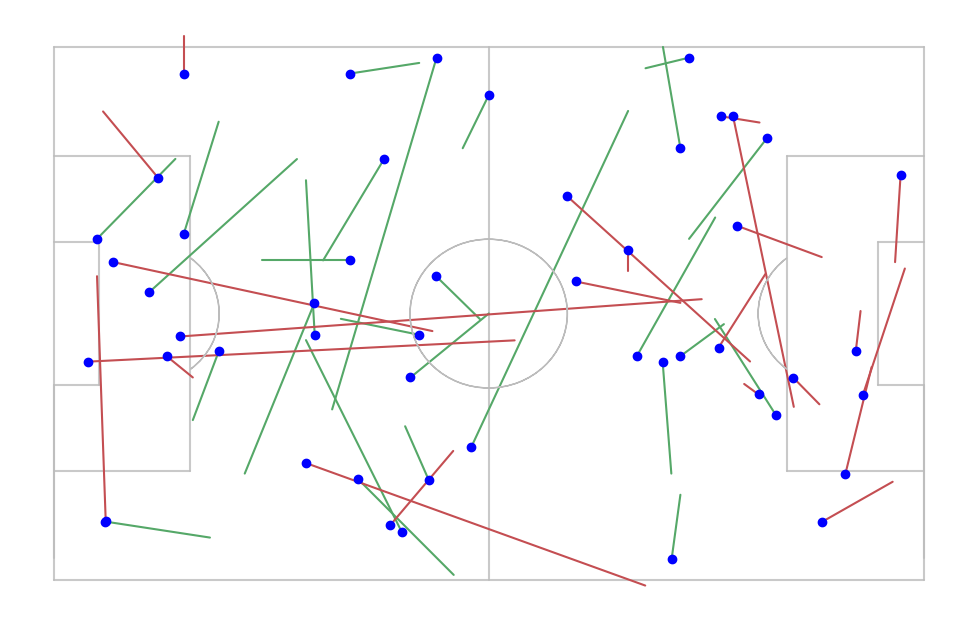

In [309]:
# Predicted success results
ax = draw_field()

ax.scatter(df_draw_model["norm_origin_pos_x"]*ww,df_draw_model["norm_origin_pos_y"]*hh, color='blue', zorder=10)

df_draw_success = df_draw_model[df_draw_model['predict_success'] == 1]
df_draw_failed  = df_draw_model[df_draw_model['predict_success'] == 0]

x_values_success = [df_draw_success["norm_origin_pos_x"]*ww,df_draw_success["norm_destination_pos_x"]*ww]
y_values_success = [df_draw_success["norm_origin_pos_y"]*hh,df_draw_success["norm_destination_pos_y"]*hh]

x_values_failed = [df_draw_failed["norm_origin_pos_x"]*ww,df_draw_failed["norm_destination_pos_x"]*ww]
y_values_failed = [df_draw_failed["norm_origin_pos_y"]*hh,df_draw_failed["norm_destination_pos_y"]*hh]

ax.plot(x_values_success, y_values_success, color='g', linestyle="-")
ax.plot(x_values_failed,  y_values_failed,  color='r', linestyle="-")

plt.show()